# **Driving Drowsiness Detection** - Validation

----------
*Master's in Automation and Robotics - ETSII (UPM)*\
**Subject:** Computer Vision\
**Course:** 2023-24\
**Student Name (ID):**
- Ivonne Quishpe (23146)
- Gustavo Maldonado (23102)
- Jorge Guijarro (23075)
- Micaela Cabrera (23023)
- Josep Mª Barberá (17048)

**Date:** December, 6

------------


Libraries

In [ ]:
try:
  if DATA_IS_LOADED:
    pass
except:
    !pip install mediapipe
    !wget -O face_landmarker_v2_with_blendshapes.task -q https://storage.googleapis.com/mediapipe-models/face_landmarker/face_landmarker/float16/1/face_landmarker.task
DATA_IS_LOADED = True
from google.colab.patches import cv2_imshow
import cv2
import mediapipe as mp
from mediapipe.framework.formats import landmark_pb2
from mediapipe import solutions
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import numpy as np
from google.colab import drive
import glob
drive.mount('/content/drive/', force_remount=True)

# For Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd

## **Feature Extraction**

In [3]:
def draw_landmarks_on_image(rgb_image, detection_result):
  face_landmarks_list = detection_result.face_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected faces to visualize.
  for idx in range(len(face_landmarks_list)):
    face_landmarks = face_landmarks_list[idx]

    # Draw the face landmarks.
    face_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    face_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in face_landmarks])
    # solutions.drawing_utils.draw_landmarks(
    #     image = annotated_image,
    #     landmark_list = face_landmarks_proto,
    #     connections = mp.solutions.face_mesh.FACEMESH_LEFT_EYE,
    #     landmark_drawing_spec = None,
    #     connection_drawing_spec = mp.solutions.drawing_styles
    #     .get_default_face_mesh_contours_style())
    # solutions.drawing_utils.draw_landmarks(
    #     image = annotated_image,
    #     landmark_list = face_landmarks_proto,
    #     connections = mp.solutions.face_mesh.FACEMESH_RIGHT_EYE,
    #     landmark_drawing_spec = None,
    #     connection_drawing_spec = mp.solutions.drawing_styles
    #     .get_default_face_mesh_contours_style())
    # solutions.drawing_utils.draw_landmarks(
    #     image = annotated_image,
    #     landmark_list = face_landmarks_proto,
    #     connections = mp.solutions.face_mesh.FACEMESH_LIPS,
    #     landmark_drawing_spec = None,
    #     connection_drawing_spec = mp.solutions.drawing_styles
    #     .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
       image = annotated_image,
       landmark_list = face_landmarks_proto,
       connections = mp.solutions.face_mesh.FACEMESH_CONTOURS,
       landmark_drawing_spec = None,
       connection_drawing_spec = mp.solutions.drawing_styles
       .get_default_face_mesh_contours_style())
    solutions.drawing_utils.draw_landmarks(
       image = annotated_image,
       landmark_list = face_landmarks_proto,
       connections = mp.solutions.face_mesh.FACEMESH_TESSELATION,
       landmark_drawing_spec = None,
       connection_drawing_spec = mp.solutions.drawing_styles
       .get_default_face_mesh_tesselation_style())

    solutions.drawing_utils.draw_landmarks(
       image = annotated_image,
       landmark_list = face_landmarks_proto,
       connections = mp.solutions.face_mesh.FACEMESH_IRISES,
         landmark_drawing_spec = None,
         connection_drawing_spec = mp.solutions.drawing_styles
         .get_default_face_mesh_iris_connections_style())

  return annotated_image

In [4]:
def get_face_points(detection_result):
  # Save the landmark coordinates for  the eyes
  right_landmarks = [33, 160, 157, 133, 153, 144]
  right_eye_points = []
  for landmark in right_landmarks:
    right_eye_points.append([detection_result.face_landmarks[0][landmark].x,
                            detection_result.face_landmarks[0][landmark].y,
                            detection_result.face_landmarks[0][landmark].z])

  left_landmarks = [362, 385, 388, 263, 373, 380]
  left_eye_points = []
  for landmark in left_landmarks:
    left_eye_points.append([detection_result.face_landmarks[0][landmark].x,
                            detection_result.face_landmarks[0][landmark].y,
                            detection_result.face_landmarks[0][landmark].z])

  # Save the landmark coordinates for  the mouth
  mouth_landmarks = [78, 81, 13, 311, 308, 402, 14, 178]
  mouth_points = []
  for landmark in mouth_landmarks:
    mouth_points.append([detection_result.face_landmarks[0][landmark].x,
                            detection_result.face_landmarks[0][landmark].y,
                            detection_result.face_landmarks[0][landmark].z])
  return right_eye_points, left_eye_points, mouth_points

In [5]:
def get_EARs(l_p, r_p):

  p2_p6 = np.linalg.norm(l_p[1]-l_p[5])
  p3_p5 = np.linalg.norm(l_p[2]-l_p[4])
  p1_p4 = np.linalg.norm(l_p[0]-l_p[3])
  left_EAR = (p2_p6 + p3_p5)/(2*p1_p4)

  p2_p6 = np.linalg.norm(r_p[1]-r_p[5])
  p3_p5 = np.linalg.norm(r_p[2]-r_p[4])
  p1_p4 = np.linalg.norm(r_p[0]-r_p[3])
  right_EAR = (p2_p6 + p3_p5)/(2*p1_p4)

  return left_EAR, right_EAR

In [6]:
def get_MAR(m_p):

  p2_p8 = np.linalg.norm(m_p[1]-m_p[7])
  p3_p7= np.linalg.norm(m_p[2]-m_p[6])
  p4_p6 = np.linalg.norm(m_p[3]-m_p[5])
  p1_p5 = np.linalg.norm(m_p[0]-m_p[4])
  MAR = (p2_p8 + p3_p7 + p4_p6)/(2*p1_p5)

  return MAR

In [7]:
def face_mesh(image_path):
    base_options = python.BaseOptions(model_asset_path='face_landmarker_v2_with_blendshapes.task')
    options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
    detector = vision.FaceLandmarker.create_from_options(options)

    # Load the input image.
    my_image = cv2.imread(image_path)
    image = mp.Image(image_format=mp.ImageFormat.SRGB, data=my_image)

    # Detect face landmarks from the input image.

    detection_result = detector.detect(image)

    right_eye_points, left_eye_points, mouth_points = get_face_points(detection_result)
    left_EAR, right_EAR = get_EARs(np.array(left_eye_points), np.array(right_eye_points))
    MAR = get_MAR(np.array(mouth_points))

    return left_EAR, right_EAR, MAR

In [8]:
def from_data_to_number(l_EAR, r_EAR, MAR):
  if (l_EAR < 0.15):
    first = "1"
  else:
    first = "0"

  if (r_EAR < 0.15):
    second = "1"
  else:
    second = "0"

  if (MAR < 0.17):
    third = "1"
  else:
    third = "0"

  return first + second + third

In [ ]:
path = r"/content/drive/MyDrive/MUAR/Vision_por_Computador/Pruebas_y_validacion/Fotos*"
folders = glob.glob(path)
y_pred = []
y_true = []

for folder in folders:
  # print(f"opening folder {folder}")
  sub_folders = glob.glob(folder + "/*")
  for sub_folder in sub_folders:
    # print(f"opening subfolder {sub_folder}")
    files = glob.glob(sub_folder + "/*.jpg")
    i = 4
    j = 7
    if (files == []):
      files = glob.glob(sub_folder + "/*.jpeg")
      i = 5
      j = 8
      if (files == []):
        files = glob.glob(sub_folder + "/*.JPEG")
        i = 5
        j = 8
        if (files == []):
          print("there are not photos in this folder...")
    for myfile in files:
      try:
        l_EAR, r_EAR, MAR = face_mesh(myfile)
        prediction = from_data_to_number(l_EAR, r_EAR, MAR)
        y_pred.append(prediction)
        actual = myfile[-j:-i]
        y_true.append(actual)
      except:
        print(f"no output for file: {myfile}")

109


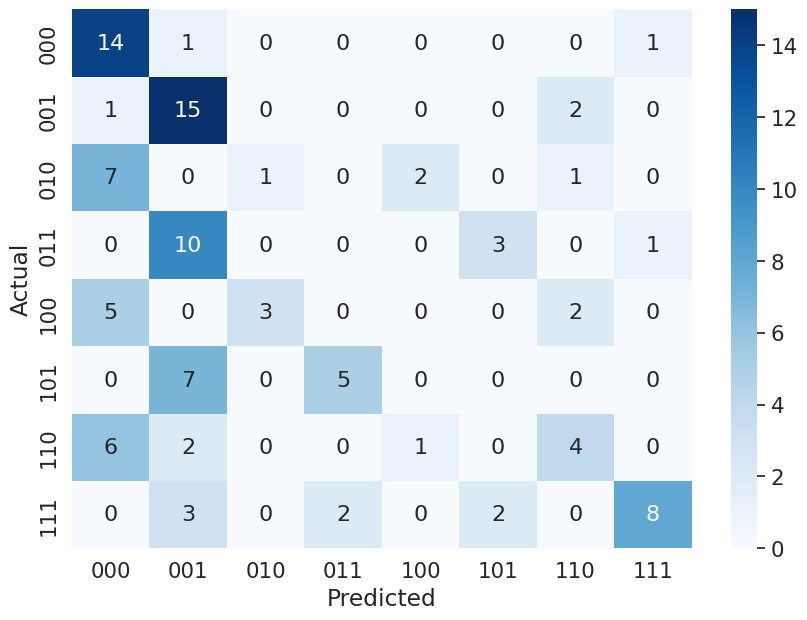

In [23]:
print(len(y_true))
data = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_true), index = np.unique(y_true))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')


In [22]:
# success rate
b = df_cm.values

print(f"Succes rate = {np.trace(b)/len(y_true)*100:.3}%")


Succes rate = 38.5%
